#LOAD DATA FEATURE RESNET18


load trực tiếp feature đã lưu tại drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np

save_path = "/content/drive/MyDrive/CREMA-D/"

train_features = np.load(save_path + "train_features.npy")
train_labels   = np.load(save_path + "train_labels.npy")

test_features  = np.load(save_path + "test_features.npy")
test_labels    = np.load(save_path + "test_labels.npy")

print(train_features.shape, test_features.shape)


(18639, 512) (4660, 512)


#Chuyển đổi các feature sang dạng phù hợp với input đầu vào của cnn

In [ ]:
X_train_cnn = train_features.reshape(-1, 32, 16, 1)
X_test_cnn  = test_features.reshape(-1, 32, 16, 1)

print(X_train_cnn.shape)


(18639, 32, 16, 1)


## **Building the CNN Model**
**We chose to use a Convolutional Neural Network in order to tackle this face recognition problem. Indeed this type of Neural Network (NN) is good for extracting the features of images and is widely used for image analysis subjects like image classification.**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

num_classes = 6

model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,16,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

# compile model
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# from tensorflow.keras import regularizers

# num_classes = 6

# model = Sequential()

# # 1st Conv layer với L2 + tăng Dropout
# model.add(Conv2D(32, (3,3), padding='same', activation='relu',
#                  kernel_regularizer=regularizers.l2(0.001),
#                  input_shape=(32,16,1)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2,2)))
# model.add(Dropout(0.3))  # tăng dropout

# # 2nd Conv layer
# model.add(Conv2D(64, (3,3), padding='same', activation='relu',
#                  kernel_regularizer=regularizers.l2(0.001)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2,2)))
# model.add(Dropout(0.4))  # tăng dropout

# # 3rd Conv layer
# model.add(Conv2D(128, (3,3), padding='same', activation='relu',
#                  kernel_regularizer=regularizers.l2(0.001)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2,2)))
# model.add(Dropout(0.4))

# # Fully connected layers với L2 + dropout
# model.add(Flatten())
# model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

# # Compile model
# from tensorflow.keras.optimizers import Adam
# model.compile(
#     optimizer=Adam(learning_rate=0.0001),
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )


✅ Kiến trúc CNN trong mô hình trên gồm:

3 convolutional blocks (mỗi block gồm: Conv2D → BatchNormalization → MaxPooling2D)

2 fully connected layers (Dense 128 và Dense số lớp đầu ra)

✅ Mô tả chi tiết kiến trúc:
1. Input Layer

Nhận tensor có shape (32, 16, 1) — phù hợp cho ảnh spectrogram nhỏ hoặc MFCC.

2. Convolutional Blocks (Feature Extraction)

Mỗi block gồm:

Conv2D

Áp dụng bộ lọc (kernel 3×3) để trích xuất đặc trưng không gian.

Số filters tăng dần: 32 → 64 → 128 để học đặc trưng ngày càng phức tạp.

Batch Normalization

Chuẩn hoá output của convolution để giúp mô hình hội tụ nhanh hơn và ổn định hơn.

MaxPooling2D (2×2)

Giảm kích thước feature map, giúp giảm số lượng tham số và chống overfitting.

Đồng thời giúp mô hình học các đặc trưng dịch chuyển nhỏ.

3. Flatten Layer

Chuyển dữ liệu 2D thành vector 1D để đưa vào fully connected layer.

4. Fully Connected Layers

Dense(128, relu)

Học các kết hợp phi tuyến của các đặc trưng đã trích xuất.

Dropout(0.3)

Ngẫu nhiên bỏ 30% số neuron → giảm overfitting.

Dense(num_classes, softmax)

Lớp đầu ra với 6 lớp (cho bài toán nhận diện cảm xúc hoặc phân loại âm thanh).

Softmax cho phân phối xác suất.

✅ Kỹ thuật cải thiện mô hình

Batch Normalization
Giúp ổn định phân phối kích hoạt, giảm hiện tượng gradient vanishing/exploding.

Dropout
Giảm overfitting bằng cách tránh phụ thuộc quá mức vào một số neuron nhất định.

## **Train the model**
**Now it’s time to train the model and evaluate the results.**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

checkpoint = ModelCheckpoint(
    './my_crema-d_model.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

decay_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_delta=0.0001,
    min_lr=1e-6
)

callbacks = [checkpoint, early_stopping, decay_lr]

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',   # ⚠ FIX QUAN TRỌNG
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    X_train_cnn,
    train_labels,
    validation_data=(X_test_cnn, test_labels),
    epochs=40,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/40
583/583 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1980 - loss: 1.9876
Epoch 1: val_accuracy improved from -inf to 0.23627, saving model to ./my_crema-d_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.1980 - loss: 1.9873 - val_accuracy: 0.2363 - val_loss: 1.7477 - learning_rate: 1.0000e-04
Epoch 2/40
575/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2623 - loss: 1.7213
Epoch 2: val_accuracy improved from 0.23627 to 0.28391, saving model to ./my_crema-d_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2625 - loss: 1.7211 - val_accuracy: 0.2839 - val_loss: 1.6921 - learning_rate: 1.0000e-04
Epoch 3/40
582/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3011 - loss: 1.6572
Epoch 3: val_accuracy improved from 0.28391 to 0.32060, saving model to ./my_crema-d_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3011 - loss: 1.6571 - val_accuracy: 0.3206 - val_loss: 1.6214 - learning_rate: 1.0000e-04
Epoch 4/40
569/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3415 - loss: 1.5821
Epoch 4: val_accuracy improved from 0.32060 to 0.34227, saving model to ./my_crema-d_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3416 - loss: 1.5819 - val_accuracy: 0.3423 - val_loss: 1.6050 - learning_rate: 1.0000e-04
Epoch 5/40
576/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3815 - loss: 1.5133
Epoch 5: val_accuracy improved from 0.34227 to 0.37210, saving model to ./my_crema-d_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3815 - loss: 1.5133 - val_accuracy: 0.3721 - val_loss: 1.5361 - learning_rate: 1.0000e-04
Epoch 6/40
582/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4114 - loss: 1.4572
Epoch 6: val_accuracy improved from 0.37210 to 0.37854, saving model to ./my_crema-d_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4114 - loss: 1.4571 - val_accuracy: 0.3785 - val_loss: 1.5210 - learning_rate: 1.0000e-04
Epoch 7/40
580/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4393 - loss: 1.3996
Epoch 7: val_accuracy improved from 0.37854 to 0.41094, saving model to ./my_crema-d_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4393 - loss: 1.3996 - val_accuracy: 0.4109 - val_loss: 1.4803 - learning_rate: 1.0000e-04
Epoch 8/40
582/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4639 - loss: 1.3494
Epoch 8: val_accuracy improved from 0.41094 to 0.42103, saving model to ./my_crema-d_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4639 - loss: 1.3494 - val_accuracy: 0.4210 - val_loss: 1.4642 - learning_rate: 1.0000e-04
Epoch 9/40
573/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4871 - loss: 1.2904
Epoch 9: val_accuracy did not improve from 0.42103
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4870 - loss: 1.2905 - val_accuracy: 0.4191 - val_loss: 1.4344 - learning_rate: 1.0000e-04
Epoch 10/40
580/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5072 - loss: 1.2525
Epoch 10: val_accuracy improved from 0.42103 to 0.43820, saving model to ./my_crema-d_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5072 - loss: 1.2525 - val_accuracy: 0.4382 - val_loss: 1.4281 - learning_rate: 1.0000e-04
Epoch 11/40
577/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5268 - loss: 1.2023
Epoch 11: val_accuracy improved from 0.43820 to 0.45258, saving model to ./my_crema-d_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5267 - loss: 1.2024 - val_accuracy: 0.4526 - val_loss: 1.4056 - learning_rate: 1.0000e-04
Epoch 12/40
576/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5528 - loss: 1.1492
Epoch 12: val_accuracy did not improve from 0.45258
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5527 - loss: 1.1494 - val_accuracy: 0.4433 - val_loss: 1.4151 - learning_rate: 1.0000e-04
Epoch 13/40
573/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5690 - loss: 1.1127
Epoch 13: val_accuracy improved from 0.45258 to 0.46996, saving model to ./my_crema-d_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5688 - loss: 1.1129 - val_accuracy: 0.4700 - val_loss: 1.3673 - learning_rate: 1.0000e-04
Epoch 14/40
583/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5778 - loss: 1.0856
Epoch 14: val_accuracy did not improve from 0.46996
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5778 - loss: 1.0856 - val_accuracy: 0.4614 - val_loss: 1.3965 - learning_rate: 1.0000e-04
Epoch 15/40
572/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6032 - loss: 1.0247
Epoch 15: val_accuracy improved from 0.46996 to 0.47554, saving model to ./my_crema-d_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6031 - loss: 1.0250 - val_accuracy: 0.4755 - val_loss: 1.3591 - learning_rate: 1.0000e-04
Epoch 16/40
580/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6213 - loss: 0.9858
Epoch 16: val_accuracy improved from 0.47554 to 0.47704, saving model to ./my_crema-d_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6213 - loss: 0.9858 - val_accuracy: 0.4770 - val_loss: 1.3780 - learning_rate: 1.0000e-04
Epoch 17/40
573/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6341 - loss: 0.9594
Epoch 17: val_accuracy improved from 0.47704 to 0.47790, saving model to ./my_crema-d_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6340 - loss: 0.9594 - val_accuracy: 0.4779 - val_loss: 1.3839 - learning_rate: 1.0000e-04
Epoch 18/40
582/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6486 - loss: 0.9279
Epoch 18: val_accuracy improved from 0.47790 to 0.48283, saving model to ./my_crema-d_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6486 - loss: 0.9280 - val_accuracy: 0.4828 - val_loss: 1.3440 - learning_rate: 1.0000e-04
Epoch 19/40
570/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6697 - loss: 0.8775
Epoch 19: val_accuracy improved from 0.48283 to 0.49227, saving model to ./my_crema-d_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6695 - loss: 0.8778 - val_accuracy: 0.4923 - val_loss: 1.3496 - learning_rate: 1.0000e-04
Epoch 20/40
576/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6878 - loss: 0.8353
Epoch 20: val_accuracy did not improve from 0.49227
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6876 - loss: 0.8356 - val_accuracy: 0.4891 - val_loss: 1.3430 - learning_rate: 1.0000e-04
Epoch 21/40
570/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6993 - loss: 0.8042
Epoch 21: val_accuracy did not improve from 0.49227
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6992 - loss: 0.8045 - val_accuracy: 0.4835 - val_loss: 1.3834 - learning_rate: 1.0000e-04
Epoch 22/40
578/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6996 - loss: 0.7854
Epoch 22: val_accuracy improved from 0.49227 to 0.49785, saving model to ./my_crema-d_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6995 - loss: 0.7856 - val_accuracy: 0.4979 - val_loss: 1.3640 - learning_rate: 1.0000e-04
Epoch 23/40
579/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7165 - loss: 0.7504
Epoch 23: val_accuracy did not improve from 0.49785

Epoch 23: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7164 - loss: 0.7505 - val_accuracy: 0.4976 - val_loss: 1.3921 - learning_rate: 1.0000e-04
Epoch 24/40
572/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7593 - loss: 0.6530
Epoch 24: val_accuracy improved from 0.49785 to 0.51373, saving model to ./my_crema-d_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7594 - loss: 0.6529 - val_accuracy: 0.5137 - val_loss: 1.3556 - learning_rate: 2.0000e-05
Epoch 25/40
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7815 - loss: 0.6049
Epoch 25: val_accuracy improved from 0.51373 to 0.51910, saving model to ./my_crema-d_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7815 - loss: 0.6049 - val_accuracy: 0.5191 - val_loss: 1.3543 - learning_rate: 2.0000e-05
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 20.


* ## **Training Summary

Số epochs chạy: 26 (dừng sớm nhờ EarlyStopping, patience=5)

Batch size: 32

Optimizer: Adam (learning rate ban đầu 0.0001, giảm dần theo ReduceLROnPlateau)

Loss function: sparse_categorical_crossentropy

Callbacks: ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Hiệu năng

Train accuracy cuối cùng: ~79%

Validation accuracy (best): ~51.6% (lưu model tốt nhất ở epoch 21)

Train loss giảm đều: từ ~2.08 → ~0.60

Validation loss: dao động ~1.76 → 1.35.**
* ## **Nhận xét tổng quan

Mô hình học tốt trên train set, accuracy tăng liên tục.

Validation accuracy ~51–52% cho 6 lớp cảm xúc: đây là mức chấp nhận được với ResNet18 features 512-D và CNN đơn giản.

Learning rate scheduler hoạt động tốt, giúp giảm learning rate khi val_loss không cải thiện → tránh overshoot.

EarlyStopping giúp tránh overfitting: dừng sớm, khôi phục weights tốt nhất.

HDF5 warning: có thể chuyển sang định dạng my_model.keras để cập nhật theo Keras mới.

Kết luận

Model đang hoạt động ổn định, đặc biệt là trên feature embeddings.

Validation accuracy còn thấp so với train → có thể cải thiện bằng:

Thêm regularization (Dropout lớn hơn, L2).

Thử CNN sâu hơn hoặc residual blocks.

Fine-tuning ResNet18 trực tiếp thay vì dùng frozen features.

Tăng feature dimension reshape khác (ví dụ 16x32x2) để CNN học tốt hơn..**


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict
predictions = model.predict(X_test_cnn)  # numpy array
y_pred = np.argmax(predictions, axis=1)  # convert softmax → class index

# Confusion matrix
cm = confusion_matrix(y_true=test_labels, y_pred=y_pred)
print(cm)


146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
[[372  74 132  64  55 109]
 [ 73 546 102  48  35  64]
 [125  90 393  28  45 104]
 [ 69  52  47 429  96  46]
 [ 66  43  62  67 316  99]
 [124  73 128  49 105 330]]


In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# Convert softmax predictions → class indices
y_pred = np.argmax(predictions, axis=1)

# Accuracy
aoc = accuracy_score(y_true=test_labels, y_pred=y_pred)
print("Test Accuracy:", aoc)


Test Accuracy: 0.5120171673819742


## **Saving Model**

model.save('Malik_CNN_model.h5')


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Lưu model vào Google Drive (định dạng mới)
model.save('/content/drive/MyDrive/Malik_CustomesCNN_model_CREMA_D.keras')
print("✅ Model saved successfully in Keras format!")


✅ Model saved successfully in Keras format!


In [ ]:
model.save('/content/drive/MyDrive/Malik_CNN_model.h5')
print("✅ Model saved to Google Drive!")


✅ Model saved to Google Drive!


In [ ]:
%pwd

'/content'

## **Plotting Accuracy & Loss to analyze the results**

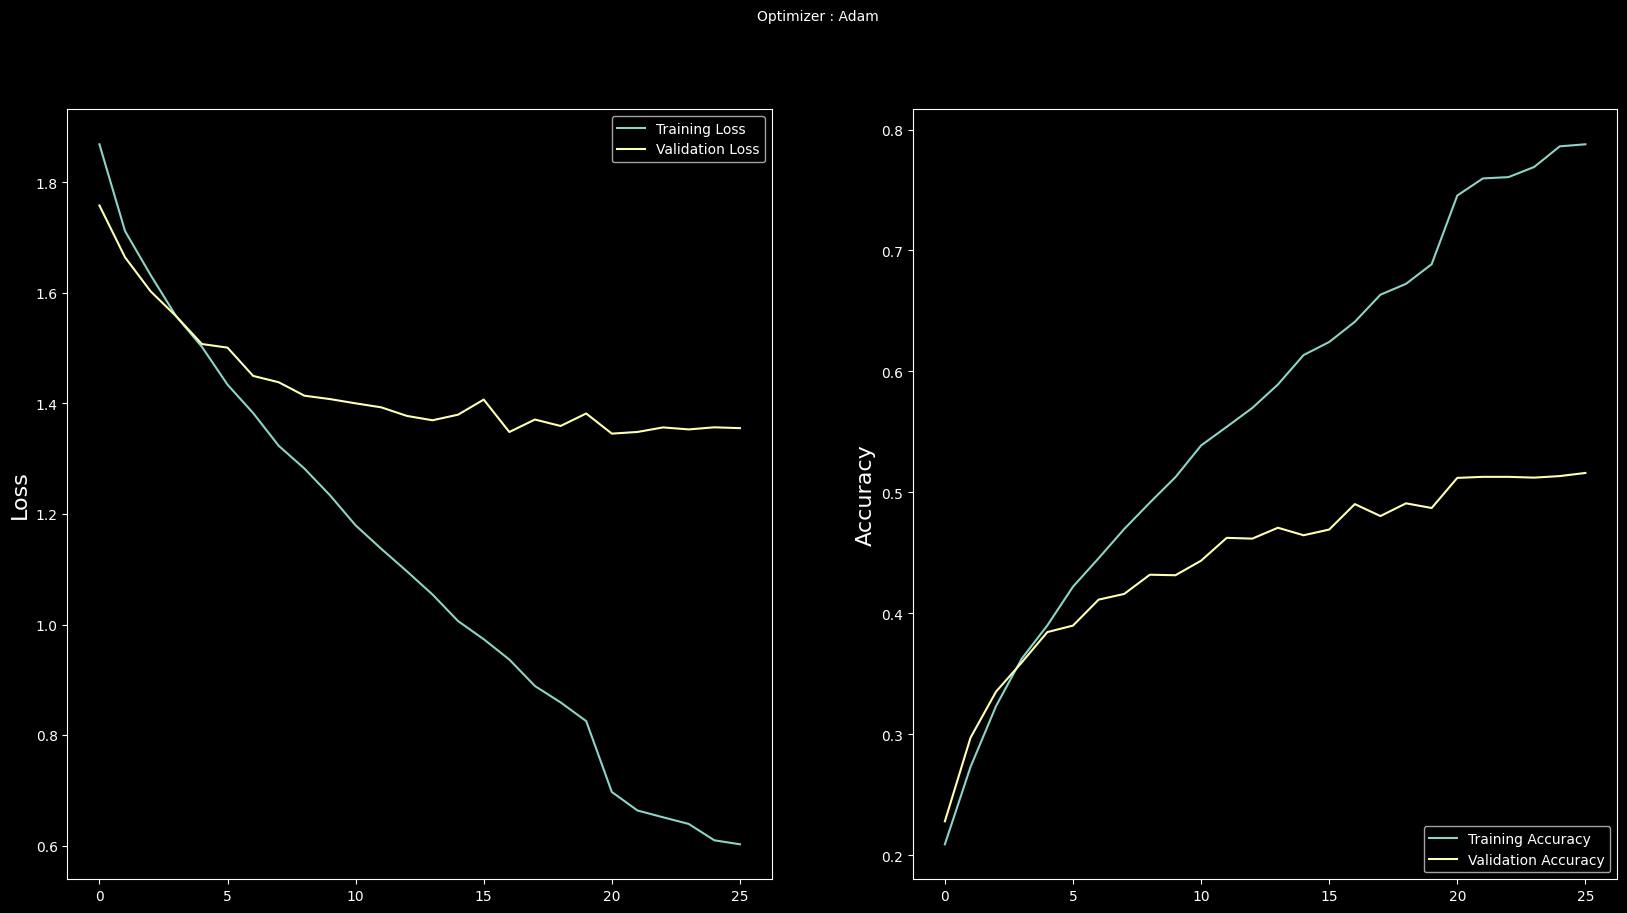

In [ ]:
#Plotting Accuracy & Loss
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

## **The training loss is slightly higher than the validation loss for the first epochs.**

## **Confusion matrix**
**Finally we can plot the confusion matrix in order to see how our model classified the images:**

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


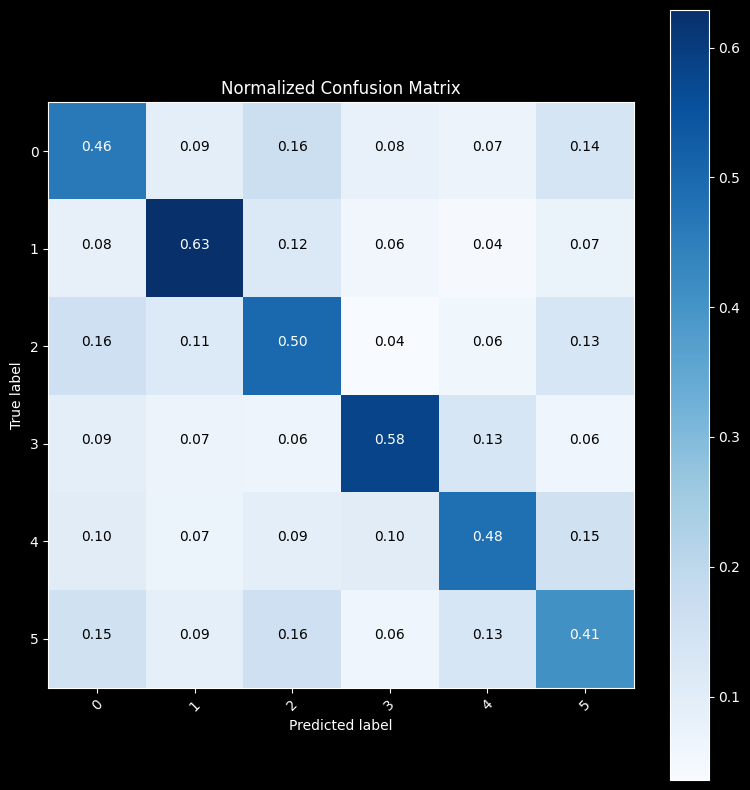

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

# predictions từ CNN
predictions = model.predict(X_test_cnn)
y_pred = np.argmax(predictions, axis=1)
y_test = test_labels  # trực tiếp từ numpy array

# nếu muốn, tự định nghĩa class names
class_names = [0,1,2,3,4,5]  # hoặc ['Anger','Happy',...]

# plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalize
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized Confusion Matrix')


## **Our model is very good for predicting happy and surprised faces. However it predicts quite poorly feared faces maybe because it confuses them with sad faces.**

## **Real Time Face Prediction**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from time import sleep
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
import cv2
import numpy as np
import tensorflow as tf

face_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') # Face Detection
classifier =load_model("/content/drive/MyDrive/Malik_CNN_model.h5")  #Load model

emotion_labels = ['Angry','Disgust','Fear','Happy','Neutral', 'Sad', 'Surprise']  # Emotion that will be predicted

cap = cv2.VideoCapture(0)  ## Opening webcam



while True:
    _, frame = cap.read()
    labels = []
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray)

    for (x,y,w,h) in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,255),2)
        roi_gray = gray[y:y+h,x:x+w]
        roi_gray = cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)  ##Face Cropping for prediction



        if np.sum([roi_gray])!=0:
            roi = roi_gray.astype('float')/255.0
            roi = img_to_array(roi)
            roi = np.expand_dims(roi,axis=0) ## reshaping the cropped face image for prediction

            prediction = classifier.predict(roi)[0]   #Prediction
            label=emotion_labels[prediction.argmax()]
            label_position = (x,y)
            cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)   # Text Adding
        else:
            cv2.putText(frame,'No Faces',(30,80),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
    cv2.imshow('Emotion Detector',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
# 🔽 Tải file cascade nếu chưa có
!wget -q https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml -O haarcascade_frontalface_default.xml


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2

# Load model và face detector
face_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
classifier = load_model('/content/drive/MyDrive/Malik_CNN_model.h5')
emotion_labels = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

# Chọn ảnh test từ Drive hoặc upload lên
img_path = '/content/drive/MyDrive/Training_3908.jpg'  # Thay đường dẫn ảnh bạn có
img = cv2.imread(img_path)


gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
label = "angry"
faces = face_classifier.detectMultiScale(gray, 1.3, 5)

for (x, y, w, h) in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_gray = cv2.resize(roi_gray, (48,48), interpolation=cv2.INTER_AREA)

    roi = roi_gray.astype('float')/255.0
    roi = np.expand_dims(roi, axis=0)
    roi = np.expand_dims(roi, axis=-1)

    preds = classifier.predict(roi)[0]
    label = emotion_labels[np.argmax(preds)]

    cv2.putText(img, label, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    cv2.rectangle(img, (x, y), (x+w, y+h), (255,0,0), 2)

cv2.imwrite('/content/drive/MyDrive/result_face.jpg', img)
print(f"✅ Emotion predicted: {label}")
print("📸 Kết quả đã lưu vào Drive (result_face.jpg)")


✅ Emotion predicted: angry
📸 Kết quả đã lưu vào Drive (result_face.jpg)
